In [1]:
import requests
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples

## Cluster Analysis Over Time ##

### 1. Load Dataset ###

In [2]:
preprocessed_df = pd.read_csv('preprocessed_df.csv', index_col=0)

In [3]:
preprocessed_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature,popularity,release_date,explicit,release_year,virality
0,0.109892,-0.399148,7,0.447035,1,0.0353,-0.626147,-0.225815,-0.612151,-0.688519,0.000427,-0.450347,3,-0.787262,1983-01-01,0,1983.0,0
1,0.312524,0.961265,9,0.782909,1,0.1450,0.040012,-0.225815,0.775918,0.880122,0.518389,-1.035873,4,-0.787262,1997-06-04,0,1997.0,0
2,1.162273,-0.833323,9,-1.570594,1,0.0329,0.900743,-0.026841,-0.660016,-0.535065,-0.658211,-0.084343,4,-0.787262,2009-01-01,0,2009.0,0
3,-0.164642,0.869606,0,-0.219940,1,0.0410,1.035954,-0.225252,0.351803,1.775271,-1.488966,0.146881,4,-0.787262,2018-12-18,0,2018.0,0
4,-2.380525,-0.698246,3,-0.788480,1,0.0377,1.045847,-0.225815,-0.647292,-1.822800,-1.185859,-0.400683,3,-0.787262,2014-03-07,0,2014.0,0


In [4]:
preprocessed_df.shape

(2266, 18)

### 2. Identify Range of Release Date ###

In [5]:
# Identify the Range of Release Date
release_date_range = preprocessed_df['release_year'].min(), preprocessed_df['release_year'].max()
print("Release Date Range:", release_date_range)

Release Date Range: (1942.0, 2024.0)


### 3. Adding 'Period' Column and Filtering Data by Decade

In [6]:
# Add the Period column based on Release Date
preprocessed_df['period'] = preprocessed_df['release_year'].apply(lambda x: 2010 if x < 2020 else 2020)

# Filter data by decades using the 'Release Year' column
df_less_1980 = preprocessed_df[(preprocessed_df['release_year'] <= 1990)]
df_1990 = preprocessed_df[(preprocessed_df['release_year'] > 1990) & (preprocessed_df['release_year'] <= 2000)]
df_2000 = preprocessed_df[(preprocessed_df['release_year'] > 2000) & (preprocessed_df['release_year'] <= 2009)]
df_2010 = preprocessed_df[(preprocessed_df['release_year'] > 2010) & (preprocessed_df['release_year'] <= 2019)]
df_2020 = preprocessed_df[(preprocessed_df['release_year'] > 2020) & (preprocessed_df['release_year'] <= 2024)]

# Print the shapes of the filtered dataframes
print("1980s and Earlier Shape:", df_less_1980.shape)
print("1990s Shape:", df_1990.shape)
print("2000s Shape:", df_2000.shape)
print("2010s Shape:", df_2010.shape)
print("2020s Shape:", df_2020.shape)

1980s and Earlier Shape: (100, 19)
1990s Shape: (80, 19)
2000s Shape: (253, 19)
2010s Shape: (732, 19)
2020s Shape: (946, 19)


### 4. Prepare Data for Clustering ###

In [7]:
# Combine df_2000_2010 and df_2000
df_2000_2010 = pd.concat([df_2000, df_2010])

# Combine the data from both periods and reset the index
combined_df = pd.concat([df_2000_2010, df_2020]).reset_index(drop=True)

# Define the features to be used, including the transformed ones
features = ['danceability', 'duration_s', 'explicit', 
            'mode', 'valence', 'energy', 'tempo', 
            'loudness', 'liveness', 'instrumentalness', 'acousticness']

### 5. t-SNE with k-Means Clustering

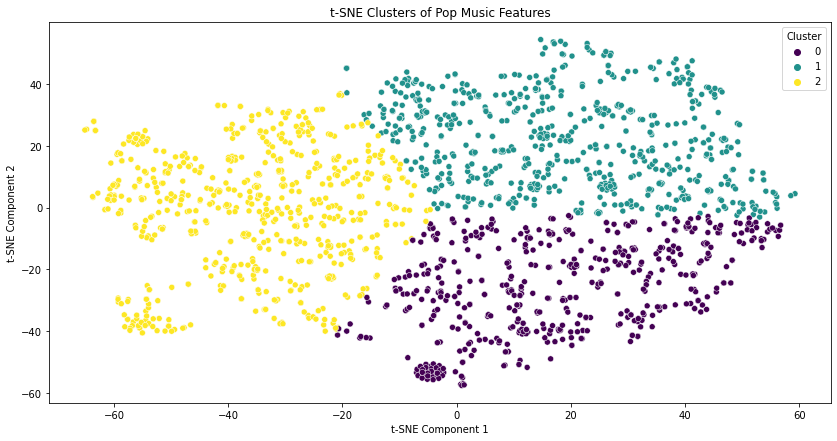

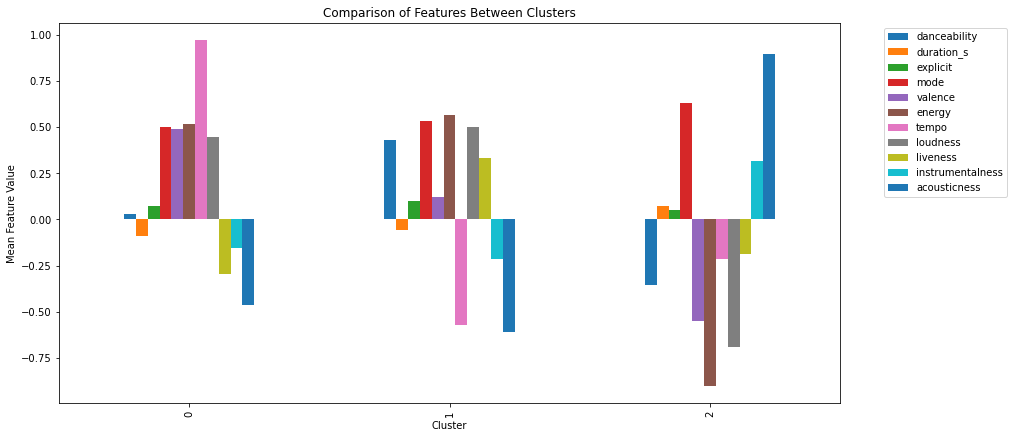

In [8]:
# Apply t-SNE to the dataset
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(combined_df[features])

# Apply K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
combined_df['Cluster'] = kmeans.fit_predict(X_tsne)

# Add t-SNE components for visualization
combined_df['t-SNE Component 1'] = X_tsne[:, 0]
combined_df['t-SNE Component 2'] = X_tsne[:, 1]

# Separate the data back into 2010 and 2020 periods
df_2010_clustered = combined_df[combined_df['period'] == 2010]
df_2020_clustered = combined_df[combined_df['period'] == 2020]

# Visualize the clusters with t-SNE components
plt.figure(figsize=(14, 7))
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='Cluster', data=combined_df, palette='viridis')
plt.title('t-SNE Clusters of Pop Music Features')
plt.show()

# Calculate the mean of each feature for each cluster
cluster_means = combined_df.groupby('Cluster').mean()[features]

# Plot the bar chart comparing all the features between clusters
cluster_means.plot(kind='bar', figsize=(14, 7))
plt.title('Comparison of Features Between Clusters')
plt.xlabel('Cluster')
plt.ylabel('Mean Feature Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [9]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_tsne, combined_df['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(X_tsne, combined_df['Cluster'])
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.2f}')

Silhouette Score: 0.40
Davies-Bouldin Index: 0.87


In [10]:
# Convert the mean values to a DataFrame
cluster_means_df = cluster_means.reset_index()

# Display the DataFrame with mean feature values
print("Mean Feature Values of Each Cluster:")
print(cluster_means_df)

Mean Feature Values of Each Cluster:
   Cluster  danceability  duration_s  explicit      mode   valence    energy  \
0        0      0.026765   -0.090583  0.073345  0.502683  0.492053  0.514879   
1        1      0.429832   -0.055603  0.098266  0.534682  0.122512  0.563669   
2        2     -0.353673    0.073330  0.050000  0.629412 -0.548096 -0.903080   

      tempo  loudness  liveness  instrumentalness  acousticness  
0  0.970576  0.448827 -0.294806         -0.152534     -0.462954  
1 -0.572572  0.497830  0.333583         -0.212342     -0.611997  
2 -0.217176 -0.689168 -0.188319          0.318421      0.898061  


### Cluster Interpretations with Sub-Genres of Pop Music

#### Cluster 0: **Electropop**
- **Danceability:** Slightly above average, making the songs quite suitable for dancing.
- **Duration (s):** Slightly shorter than average.
- **Explicit Content:** Moderately explicit, indicating a noticeable amount of explicit lyrics.
- **Mode:** Major key, giving the songs a brighter sound.
- **Valence:** Positive, conveying more cheerful and upbeat emotions.
- **Energy:** Above average, indicating a lively and energetic feel.
- **Tempo:** Faster, contributing to an upbeat pace.
- **Loudness:** Moderately loud, creating a strong listening experience.
- **Liveness:** Lower, making the songs feel more studio-produced.
- **Instrumentalness:** Low, focusing more on vocals.
- **Acousticness:** Low, being more electronic in nature.

#### Cluster 1: **Dance Pop**
- **Danceability:** High, making the songs very suitable for dancing.
- **Duration (s):** Slightly shorter than average.
- **Explicit Content:** Moderately explicit, suggesting some explicit lyrics.
- **Mode:** Major key, giving the songs a brighter and more positive sound.
- **Valence:** Slightly positive, often conveying upbeat emotions.
- **Energy:** High, indicating an intense and lively feel.
- **Tempo:** Slower, contributing to a balanced pace.
- **Loudness:** Moderately loud, creating a strong listening experience.
- **Liveness:** Higher, indicating a more live performance feel.
- **Instrumentalness:** Low, focusing more on vocals.
- **Acousticness:** Low, being more electronic in nature.

#### Cluster 2: **Acoustic Pop**
- **Danceability:** Low, indicating the songs are less suitable for dancing.
- **Duration (s):** Slightly longer than average.
- **Explicit Content:** Lower, suggesting fewer explicit lyrics.
- **Mode:** Major key, giving the songs a brighter sound.
- **Valence:** Negative, often conveying more somber or introspective emotions.
- **Energy:** Very low, indicating a softer and more mellow intensity.
- **Tempo:** Slower, contributing to a more relaxed pace.
- **Loudness:** Quite low, creating a softer listening experience.
- **Liveness:** Lower, indicating a more studio-produced feel.
- **Instrumentalness:** Higher, focusing more on instrumentals.
- **Acousticness:** High, featuring a significant amount of acoustic characteristics.

### 6. Visualize Clusters

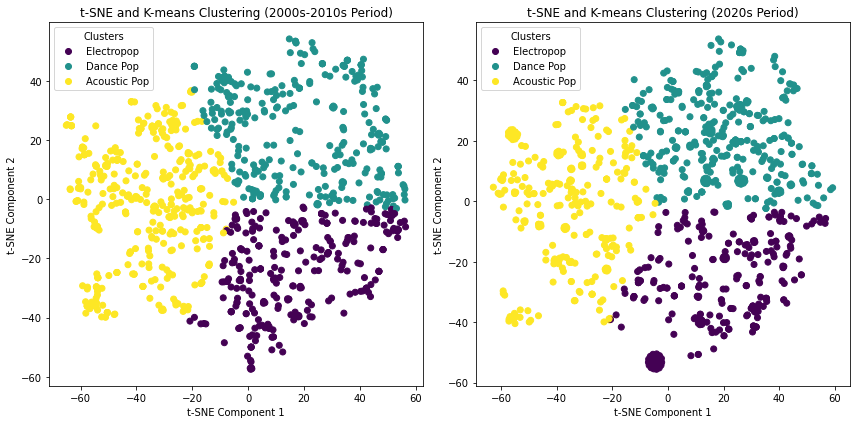

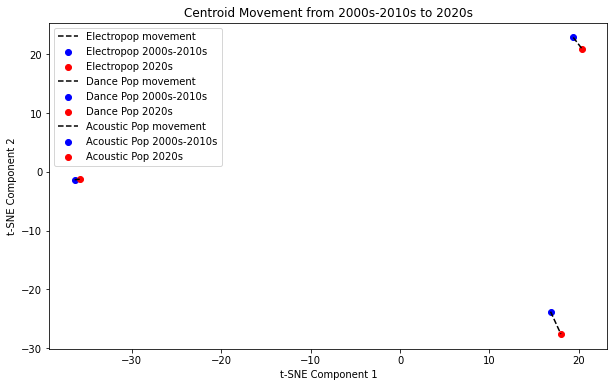

In [11]:
# Cluster labels based on the updated cluster names
cluster_labels = ['Electropop', 'Dance Pop', 'Acoustic Pop']

# Visualize the clusters for the 2000s-2010s period
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(df_2010_clustered['t-SNE Component 1'], df_2010_clustered['t-SNE Component 2'], c=df_2010_clustered['Cluster'], cmap='viridis')
plt.title('t-SNE and K-means Clustering (2000s-2010s Period)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add legend for the 2000s-2010s period
plt.legend(handles=scatter1.legend_elements()[0], labels=cluster_labels[:len(scatter1.legend_elements()[0])], title="Clusters")

# Visualize the clusters for the 2020s period
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df_2020_clustered['t-SNE Component 1'], df_2020_clustered['t-SNE Component 2'], c=df_2020_clustered['Cluster'], cmap='viridis')
plt.title('t-SNE and K-means Clustering (2020s Period)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add legend for the 2020s period
plt.legend(handles=scatter2.legend_elements()[0], labels=cluster_labels[:len(scatter2.legend_elements()[0])], title="Clusters")

plt.tight_layout()
plt.show()

# Calculate centroids for each period
centroids_2010 = df_2010_clustered.groupby('Cluster').mean()[['t-SNE Component 1', 't-SNE Component 2']]
centroids_2020 = df_2020_clustered.groupby('Cluster').mean()[['t-SNE Component 1', 't-SNE Component 2']]

# Ensure centroids and labels are of the same length
valid_clusters = min(len(centroids_2010), len(centroids_2020), len(cluster_labels))

# Visualize centroid movement
plt.figure(figsize=(10, 6))
for i in range(valid_clusters):
    plt.plot([centroids_2010.iloc[i, 0], centroids_2020.iloc[i, 0]], [centroids_2010.iloc[i, 1], centroids_2020.iloc[i, 1]], 'k--', label=f'{cluster_labels[i]} movement')
    plt.scatter(centroids_2010.iloc[i, 0], centroids_2010.iloc[i, 1], c='blue', label=f'{cluster_labels[i]} 2000s-2010s')
    plt.scatter(centroids_2020.iloc[i, 0], centroids_2020.iloc[i, 1], c='red', label=f'{cluster_labels[i]} 2020s')

plt.title('Centroid Movement from 2000s-2010s to 2020s')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')
plt.show()

Feature Shifts from 2000s-2010s to 2020:
         danceability  duration_s  explicit      mode   valence    energy  \
Cluster                                                                     
0            0.278197   -0.406852  0.041729 -0.058963 -0.061752 -0.263452   
1            0.496346   -0.339572  0.069656 -0.143202 -0.018488 -0.165027   
2            0.150175   -0.202142 -0.022171  0.035670 -0.030459  0.057892   

            tempo  loudness  liveness  instrumentalness  acousticness  
Cluster                                                                
0        0.084889 -0.018037 -0.066547         -0.046690     -0.158334  
1        0.003121 -0.014879 -0.301154         -0.013217     -0.132761  
2        0.008950  0.164714 -0.104370         -0.097858      0.009105  

Cluster 0 (Electropop):
  danceability: increased by 0.2782
  duration_s: decreased by 0.4069
  explicit: increased by 0.0417
  mode: decreased by 0.0590
  valence: decreased by 0.0618
  energy: decreased by 0.26

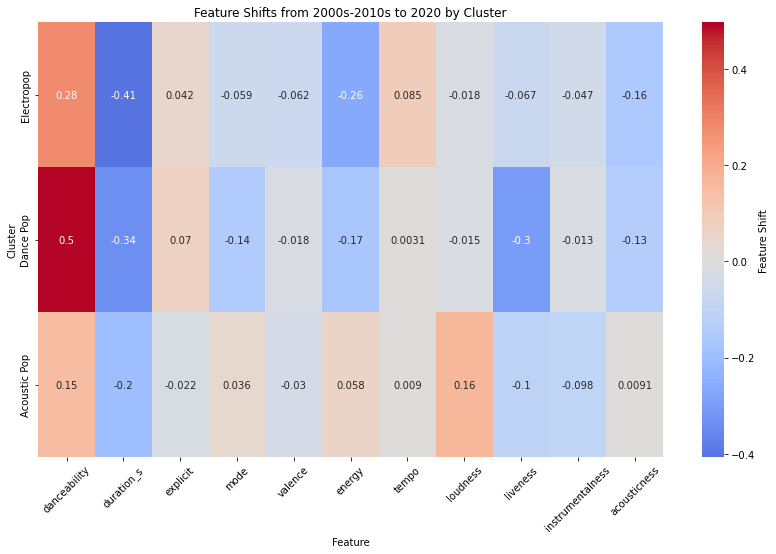

In [12]:
# Calculate the mean feature values for each cluster in 2010 and 2020
mean_features_2010 = df_2010_clustered.groupby('Cluster').mean()[features]
mean_features_2020 = df_2020_clustered.groupby('Cluster').mean()[features]

# Calculate the shifts in feature values
feature_shifts = mean_features_2020 - mean_features_2010

# Print the shifts for each cluster
print("Feature Shifts from 2000s-2010s to 2020:")
print(feature_shifts)

# Describe the changes in audio features related to the shift
for cluster in range(3):
    print(f"\nCluster {cluster} ({cluster_labels[cluster]}):")
    for feature in features:
        shift = feature_shifts.loc[cluster, feature]
        if shift > 0:
            change = "increased"
        elif shift < 0:
            change = "decreased"
        else:
            change = "remained the same"
        print(f"  {feature}: {change} by {abs(shift):.4f}")

# Assign cluster labels to the feature shifts dataframe for visualization
feature_shifts.index = cluster_labels

# Create a heatmap for the feature shifts
plt.figure(figsize=(14, 8))
sns.heatmap(feature_shifts, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Feature Shift'})
plt.title('Feature Shifts from 2000s-2010s to 2020 by Cluster')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.show()

In [13]:
feature_shifts

,danceability,duration_s,explicit,mode,valence,energy,tempo,loudness,liveness,instrumentalness,acousticness
Electropop,0.278197,-0.406852,0.041729,-0.058963,-0.061752,-0.263452,0.084889,-0.018037,-0.066547,-0.046690,-0.158334
Dance Pop,0.496346,-0.339572,0.069656,-0.143202,-0.018488,-0.165027,0.003121,-0.014879,-0.301154,-0.013217,-0.132761
Acoustic Pop,0.150175,-0.202142,-0.022171,0.035670,-0.030459,0.057892,0.008950,0.164714,-0.104370,-0.097858,0.009105


### Cluster Interpretations of Audio Feature Changes between 2000s-2010s and 2020s

#### Cluster 0: **Electropop**
- **Danceability:** The songs in this cluster have become significantly more danceable over time.
- **Duration (s):** The songs have become significantly shorter in duration.
- **Explicit Content:** There is a small increase in the amount of explicit content in the lyrics.
- **Mode:** There is a slight decrease in the use of major keys.
- **Valence:** The positivity of the songs has slightly decreased, indicating a minor shift towards more neutral or negative emotions.
- **Energy:** The energy levels have significantly decreased, making the songs a lot less energetic.
- **Tempo:** The tempo has slightly increased, suggesting a faster pace in the songs.
- **Loudness:** The songs have become marginally quieter.
- **Liveness:** There is a slight decrease in the presence of live elements, making the songs feel less like live performances.
- **Instrumentalness:** There is a slight decrease in the amount of instrumental parts.
- **Acousticness:** The songs have become less acoustic, leaning more towards electronic sounds.

**Summary:** Electropop songs have become more danceable and shorter, with a small increase in explicit content. They are now less acoustic, have fewer live elements, and are less energetic, resulting in a more polished and electronic sound.

#### Cluster 1: **Dance Pop**
- **Danceability:** The songs in this cluster have become significantly more danceable over time.
- **Duration (s):** The songs have become significantly shorter in duration.
- **Explicit Content:** There is a moderate increase in explicit content in the lyrics.
- **Mode:** There is a notable decrease in the use of major keys.
- **Valence:** The positivity of the songs has slightly decreased, making them less cheerful.
- **Energy:** The energy levels have significantly decreased, making the songs less intense.
- **Tempo:** The tempo has remained relatively stable, with a very slight increase.
- **Loudness:** The songs have become marginally quieter.
- **Liveness:** There is a significant decrease in the presence of live elements, making the songs feel more studio-produced.
- **Instrumentalness:** There is a slight decrease in the amount of instrumental parts.
- **Acousticness:** The songs have become less acoustic in nature.

**Summary:** Dance Pop songs have become more danceable and shorter, with a moderate increase in explicit content. They are now less energetic, less acoustic, and have fewer live elements, resulting in a more polished and studio-produced sound.

#### Cluster 2: **Acoustic Pop**
- **Danceability:** The songs in this cluster have become slightly more danceable over time.
- **Duration (s):** The songs have become shorter in duration.
- **Explicit Content:** There is a slight decrease in explicit content in the lyrics, indicating a shift towards cleaner lyrics.
- **Mode:** There is a slight increase in the use of major keys, giving the songs a brighter sound.
- **Valence:** The positivity of the songs has slightly decreased, making them more neutral.
- **Energy:** The energy levels have slightly increased, making the songs a bit more energetic.
- **Tempo:** The tempo has slightly increased, suggesting a faster pace in the songs.
- **Loudness:** The songs have become marginally louder.
- **Liveness:** There is a slight decrease in the presence of live elements.
- **Instrumentalness:** There is a noticeable decrease in the amount of instrumental parts.
- **Acousticness:** The songs have become slightly more acoustic in nature.

**Summary:** Acoustic Pop songs have become slightly more danceable, shorter, and louder, with cleaner lyrics and a slight increase in energy. They now feature a more acoustic and neutral sound with fewer instrumental parts and live elements.

## Sensitivity Analysis

In [14]:
# Define parameters to test
perplexity_values = [10, 20, 30, 40, 50, 60]
num_clusters_values = [3, 4, 5, 6, 7, 8, 9, 10]

results = []

for perplexity in perplexity_values:
    for num_clusters in num_clusters_values:
        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        X_tsne = tsne.fit_transform(combined_df[features])
        
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        combined_df['Cluster'] = kmeans.fit_predict(X_tsne)
        
        # Calculate evaluation metrics
        silhouette_avg = silhouette_score(X_tsne, combined_df['Cluster'])
        davies_bouldin_avg = davies_bouldin_score(X_tsne, combined_df['Cluster'])
        
        # Store results
        results.append((perplexity, num_clusters, silhouette_avg, davies_bouldin_avg))

# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results, columns=['Perplexity', 'Num Clusters', 'Silhouette Score', 'Davies-Bouldin Index'])
print(results_df)

    Perplexity  Num Clusters  Silhouette Score  Davies-Bouldin Index
0           10             3          0.392210              0.834562
1           10             4          0.381283              0.819034
2           10             5          0.359378              0.884559
3           10             6          0.376787              0.817350
4           10             7          0.362242              0.806091
5           10             8          0.360403              0.843741
6           10             9          0.343184              0.915075
7           10            10          0.352453              0.851685
8           20             3          0.394585              0.854614
9           20             4          0.370150              0.849466
10          20             5          0.369415              0.863633
11          20             6          0.373060              0.823021
12          20             7          0.375368              0.807307
13          20             8      

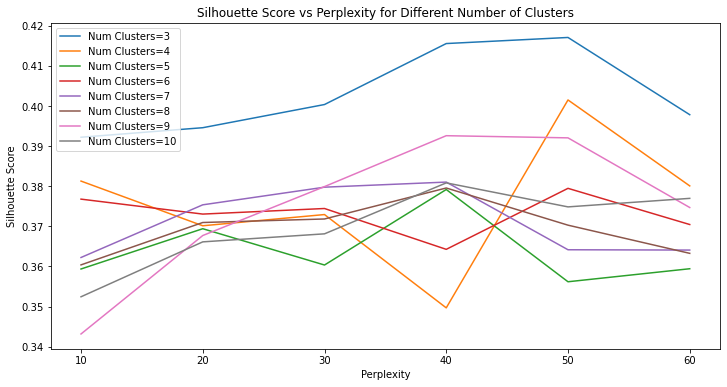

In [15]:
# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results, columns=['Perplexity', 'Num Clusters', 'Silhouette Score', 'Davies-Bouldin Index'])

# Pivot the DataFrame for heatmap visualization
silhouette_pivot = results_df.pivot('Perplexity', 'Num Clusters', 'Silhouette Score')
davies_bouldin_pivot = results_df.pivot('Perplexity', 'Num Clusters', 'Davies-Bouldin Index')

# Line plots for evaluation metrics across different perplexity values
plt.figure(figsize=(12, 6))
for num_clusters in num_clusters_values:
    subset = results_df[results_df['Num Clusters'] == num_clusters]
    plt.plot(subset['Perplexity'], subset['Silhouette Score'], label=f'Num Clusters={num_clusters}')
plt.xlabel('Perplexity')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Perplexity for Different Number of Clusters')
plt.legend()
plt.show()

In [16]:
results_df[results_df['Silhouette Score'] == results_df['Silhouette Score'].max()]

,Perplexity,Num Clusters,Silhouette Score,Davies-Bouldin Index
32,50,3,0.417072,0.863936


Given the highest Silhouette Score, the sensitivity analysis matches the optimal perplexity (50) and number of clusters (3) we determined earlier.